# Response Distributions

Lets look at the answer distributions for each of the 3 questions in out survey.

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from data_generation.join_traces_and_survey import load_survey_dfs
from response_distributions_util import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and Prep Data

In [9]:
d_survey, d_joined = load_survey_dfs()
d_desktop = d_joined[d_joined['host'] == 'mobile']
d_mobile = d_joined[d_joined['host'] == 'desktop']
d_single_motivation = d_joined[d_joined['motivation'].apply(lambda x: len(x.split('|')) == 1)]

print('Num Responses: ', d_survey.shape[0])
print('Num in EL: ', d_joined.shape[0])
print('Num Mobile Responses in EL: ', d_desktop.shape[0])
print('Num Desktop Responses in EL: ', d_mobile.shape[0])

Num Responses:  35948
Num in EL:  32792
Num Mobile Responses in EL:  15059
Num Desktop Responses in EL:  17733


## Q1 Information Depth

I am reading this article to ... [Information Depth]
* look up a specific fact or to get a quick answer. [fact]
* get an overview of the topic. [overview]
* get an in-depth understanding of the topic. [in-depth]

### Information Depth Histogram (Dektop vs Mobile)

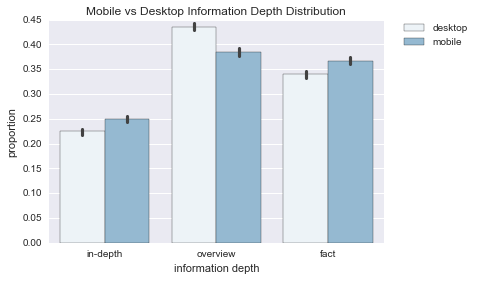

In [31]:
x = 'information depth'
hue = 'host'
title = 'Mobile vs Desktop Information Depth Distribution'
xorder  = ['in-depth', 'overview', 'fact']
plot_proportion(d_joined, x, hue, title,  xorder = xorder)

The distributions are relatively similar across mobile and desktop. The most common use case is to get an overview, then look up a fact, then get an in depth understanding.

## Q2 Familiarity

Prior to visiting this article ... [Prior Knowledge]
* I was already familiar with the topic. [familiar]
* I was not familiar with the topic and I am learning about it for the first time. [unfamiliar]

### Prior Knowledge Histogram (Dektop vs Mobile)

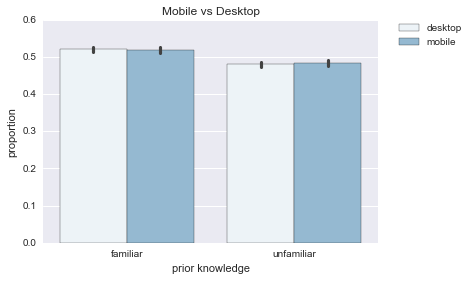

In [32]:
x = 'prior knowledge'
hue = 'host'
title = 'Mobile vs Desktop'
plot_proportion(d_joined, x, hue, title)

Desktop and mobile are basically identical. People are slightly more likely to be familiar with the topic they are reading about.

## Q3 Motivation

I am reading this article because ... [Motivation]
* I have a work or school-related assignment. [work/school]
* I need to make a personal decision based on this topic (e.g., to buy a  book or game, to choose a travel destination). [personal-decision]
* I want to know more about a current event (e.g. Black Friday, a soccer game, a recent earthquake, somebody's death). [current event]
* the topic was referenced in a piece of media (e.g. TV, radio, article, film, book). [media]
* the topic came up in a conversation. [conversation]
* I am bored or randomly exploring Wikipedia for fun. [bored/random]
* this topic is important to me and I want to learn more about it. (e.g., to learn about a culture). [intrinsic_learning]

### Number of Motivations Distribution

Subjects were allowed to select multiple reasons. How many motivations do people select?

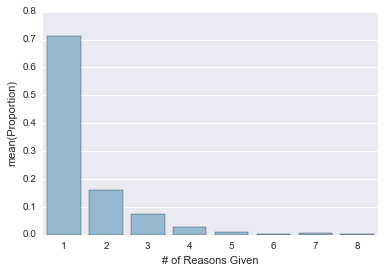

In [34]:
d_in = pd.DataFrame()
d_in['counts'] = d_joined['motivation'].apply(lambda x: len(x.split('|'))).value_counts()
d_in['Proportion'] = d_in['counts'] / d_in['counts'].sum()
d_in['# of Reasons Given'] = d_in.index

fig = sns.barplot(y="Proportion",
            x = '# of Reasons Given',
            data=d_in,
            color = (0.54308344686732579, 0.73391773700714114, 0.85931565621319939)
            )

30% of respondents listed more than one motivation.

### Single Motivation Histogram

For responses with only a single motivation, what is the distribution over motivations.

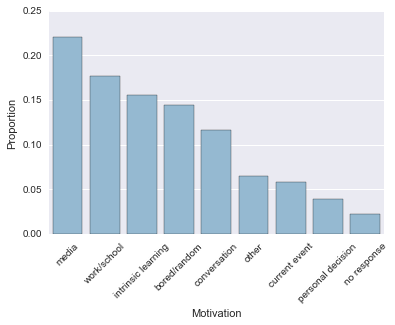

In [36]:
d_in = pd.DataFrame()
d_in['counts'] = d_single_motivation['motivation'].value_counts()
d_in['proportion'] = d_in['counts'] / d_in['counts'].sum()
d_in['motivation'] = d_in.index

fig = sns.barplot(y="proportion",
            x = 'motivation',
            data=d_in,
            color = (0.54308344686732579, 0.73391773700714114, 0.85931565621319939),
            )
plt.ylabel('Proportion')
plt.xlabel('Motivation')

for item in fig.get_xticklabels():
    item.set_rotation(45)


Media and work/school are the most popular 

### Single Motivation Histogram (Dektop vs Mobile)

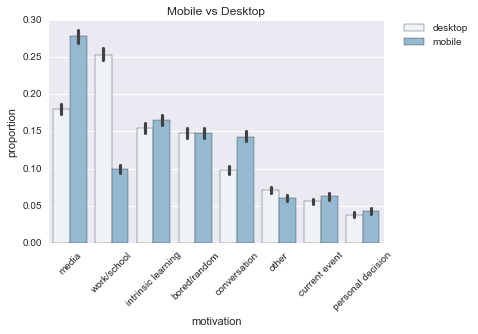

In [37]:
x = 'motivation'
hue = 'host'
title = 'Mobile vs Desktop'
order = ['media', 'work/school','intrinsic learning', 'bored/random', 'conversation', 'other','current event', 'personal decision', ]
plot_proportion(d_single_motivation, x, hue, title, xorder = order, rotate=True)

For Desktop, the most common motivation is work/school. For Mobile, it is media. Also, for mobile users, conversation is more likely compared to desktop. 

### Motivation Histogram

For each motivation lets count how often it was chosen as at least one of the motivations.

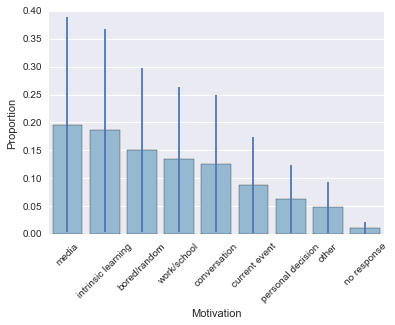

In [39]:
d_in = pd.DataFrame(columns = ['motivation', 'counts'])
ms = [
        'work/school',
        'personal decision',
        'current event',
        'media',"conversation",
        'bored/random',
        'no response',
        'intrinsic learning',
        'other'
    ]

for i, m in enumerate(ms):
     d_in.loc[i] = [m, d_joined['motivation'].apply(lambda x: m in x).sum()]


d_in['proportion'] = d_in['counts'] / d_in['counts'].sum()
d_in['err'] = d_in['counts'].apply(lambda x: get_std_err(x, d_in['counts'].sum()))
d_in.sort_values(by = 'counts', inplace = True, ascending = False)
fig = sns.barplot(y="proportion",
            x = 'motivation',
            data=d_in,
            yerr = d_in['err'],
            color = (0.54308344686732579, 0.73391773700714114, 0.85931565621319939),
            )
plt.ylabel('Proportion')
plt.xlabel('Motivation')

for item in fig.get_xticklabels():
    item.set_rotation(45)

Suddenly intrinsic learning features much more prominently. It must be a common occurence in multi-choice answers.

### Double Motivation Co-occurrence Heatmaps

For users who chose 2 motivations, which motivations co-occur?

In [21]:
df = copy.deepcopy(d_joined[d_joined['motivation'].apply(lambda x: len(x.split('|')) == 2)])
df['pm'] = df['motivation'].apply(lambda x: '|'.join(sorted(x.split('|'))))
df_joint = pd.DataFrame()
df_joint['count'] = df['pm'].value_counts()
df_joint['pm'] = df_joint.index
df_joint.index = range(0, df_joint.shape[0])
df_joint['m1'] = df_joint['pm'].apply(lambda x: x.split('|')[0])
df_joint['m2'] = df_joint['pm'].apply(lambda x: x.split('|')[1])
df_joint['count'] = df_joint['count'].apply(int)

In [22]:
df_joint2 = copy.deepcopy(df_joint)
df_joint2['pm'] = df_joint2['pm'].apply(lambda x: '|'.join(sorted(x.split('|'), reverse = True)))
df_joint2['m1'] = df_joint2['pm'].apply(lambda x: x.split('|')[0])
df_joint2['m2'] = df_joint2['pm'].apply(lambda x: x.split('|')[1])
df_joint2.index = range(df_joint.shape[0], 2 * df_joint.shape[0])

In [23]:
df_joint12 = pd.concat([df_joint, df_joint2]).pivot("m1", "m2", "count")
#ax = sns.heatmap(df_joint12, annot=True, fmt="0.0f")
#plt.ylabel('Motivation 1')
#plt.xlabel('Motivation 2')
#plt.title('Raw Co-occurence counts')

The since some motivations are more popular than others, the color coding can be misleading. Let's look at the conditional distributions instead.

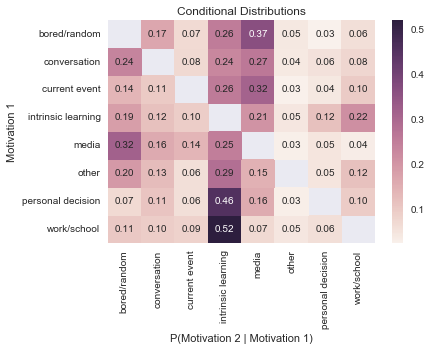

In [24]:
df_joint12_norm = df_joint12.div(df_joint12.sum(axis=1), axis=0)
ax = sns.heatmap(df_joint12_norm, annot=True, fmt="0.2f")
plt.ylabel('Motivation 1')
plt.xlabel('P(Motivation 2 | Motivation 1)')
plt.title('Conditional Distributions')

 - Given that work/school is a motivation, the most common other motivation is intrinsic_learning by a long shot. seems like people in our survey who choose 2 motivations like their job/studies
 - the pattern is similar for personal decisiions
 - Given that people are bored/randomly exploring, their most likely other motivations is media. the next most likely is intrinsic_learning
 - the pattern is similar for current events

# Response Co-occurence

## Information Depth  and  Prior Knowledge

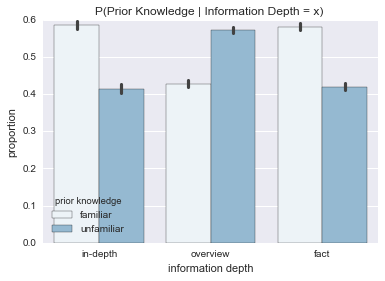

In [25]:
x = 'information depth'
hue = 'prior knowledge'
title = 'P(Prior Knowledge | Information Depth = x) '
xorder = order = ['in-depth', 'overview', 'fact']
plot_proportion(d_joined, x, hue, title,  xorder = xorder, normx=False)

When seeking in-depth information or looking up a fact, readers are more likely to be familiar with the topic. When they are seeking an overview, the are more likely to be unfamiliar.

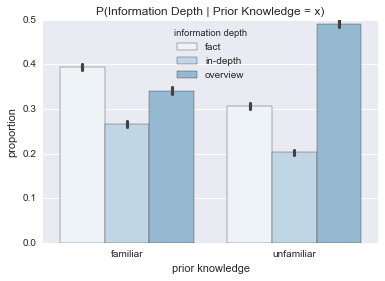

In [26]:
hue = 'information depth'
x = 'prior knowledge'
title = 'P(Information Depth | Prior Knowledge = x)'
xorder = order = ['familiar', 'unfamiliar']
plot_proportion(d_joined, x, hue, title,  xorder = xorder, normx=False)

Readers famailiar with the topic are most likely to be looking up a fact. Unfamiliar users are the most likely to be getting an overview.

## Prior Knowledge and Motivation

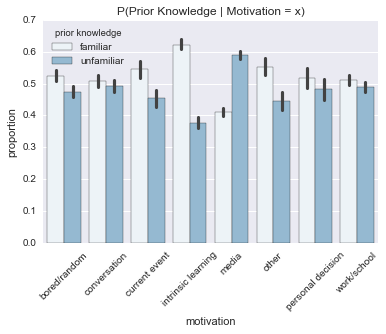

In [27]:
hue = 'prior knowledge'
x = 'motivation'
title = 'P(Prior Knowledge | Motivation = x)'
plot_proportion(d_single_motivation, x, hue, title, rotate=True, normx=False)

When people come for intrinsic learning, they tend to be familair with the topic already. When people come because of a reference in the media, they tend to be unfamialiar with the topic.

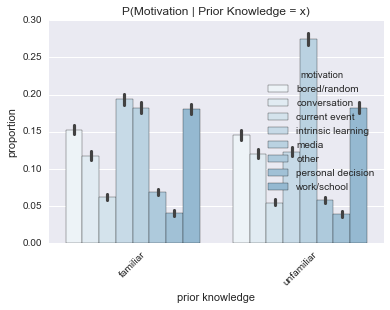

In [28]:
x = 'prior knowledge'
hue = 'motivation'
title = 'P(Motivation | Prior Knowledge = x)'
plot_proportion(d_single_motivation, x, hue, title, rotate=True, normx=False)

Bad Visualization

## Information Depth and Motivation

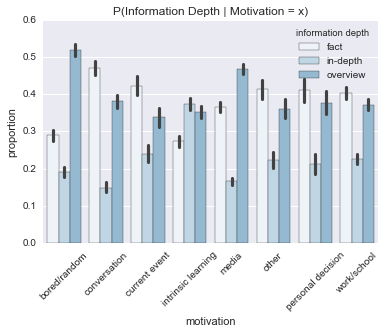

In [29]:
hue = 'information depth'
x = 'motivation'
title = 'P(Information Depth | Motivation = x)'
plot_proportion(d_single_motivation, x, hue, title, rotate=True, normx=False)

bored/random users are interested in getting an overview. Users in a conversation are loking up a fact...

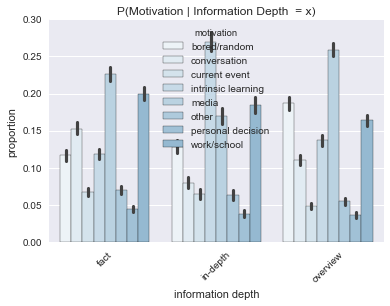

In [30]:
x = 'information depth'
hue = 'motivation'
title = 'P(Motivation | Information Depth  = x)'
plot_proportion(d_single_motivation, x, hue, title, rotate=True, normx=False)

In [ ]:
Bad Visualization